In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import pymc as pm
from pymc import HalfNormal, Model, Normal, sample
import xarray as xr
import arviz as az
import pingouin as pg

import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [3]:
younger = np.array([45, 38, 52, 48, 25, 39, 51, 46, 55, 46])
older = np.array([34, 33, 36, 38, 37, 40, 42, 43, 32, 36])

In [4]:
res = pg.ttest(older, 40)

In [5]:
print(res)

               T  dof alternative     p-val           CI95%   cohen-d   BF10  \
T-test -2.481666    9   two-sided  0.034896  [34.46, 39.74]  0.784772  2.319   

           power  
T-test  0.599895  


In [6]:
T = (np.mean(older) - 40) / (np.std(older, ddof=1) / np.sqrt(len(older)))
T


-2.481665888425312

In [7]:
df = len(older) - 1
print(df)

9


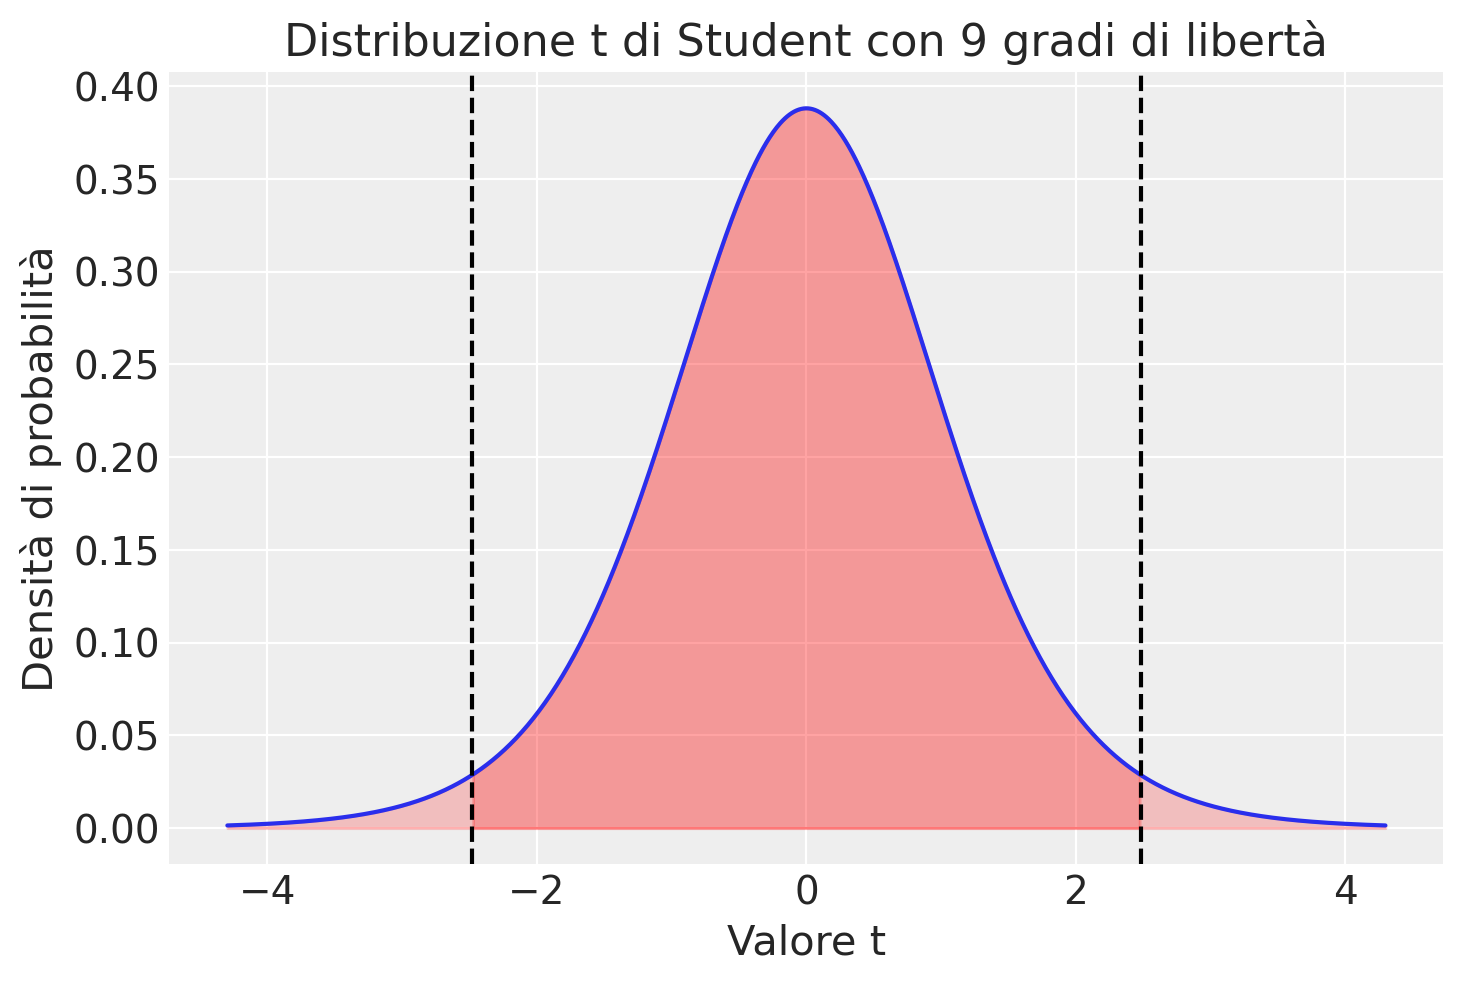

In [8]:
# Set up the x-axis values for the t-distribution plot
x = np.linspace(st.t.ppf(0.001, df), st.t.ppf(0.999, df), 1000)

# Set up the y-axis values for the t-distribution plot
y = st.t.pdf(x, df)

# Create the t-distribution plot
plt.plot(x, y, label="t-distribution")

# Shade the areas [-infinity, -T] and [T, +infinity]
plt.fill_between(x[x <= -T], y[x <= -T], color="red", alpha=0.2)
plt.fill_between(x[x >= T], y[x >= T], color="red", alpha=0.2)

# Add vertical lines for T and -T
plt.axvline(x=T, color="black", linestyle="--")
plt.axvline(x=-T, color="black", linestyle="--")


# Set the plot title and axis labels
plt.title(f"Distribuzione t di Student con {df} gradi di libertà")
plt.xlabel("Valore t")
plt.ylabel("Densità di probabilità")
plt.show()


In [9]:
st.t.cdf(T, df=len(older) - 1) * 2


0.03489593108658913

In [10]:
alpha = 0.05
df # 9
t_c = st.t.ppf(1 - alpha / 2, df)
t_c

2.262157162854099

In [11]:
ci_lower = np.mean(older) - t_c * np.std(older, ddof=1) / np.sqrt(len(older))
ci_upper = np.mean(older) + t_c * np.std(older, ddof=1) / np.sqrt(len(older))
print("L'intervallo di confidenza al 95% per la media della popolazione è: [{:.2f}, {:.2f}].".format(ci_lower, ci_upper))

L'intervallo di confidenza al 95% per la media della popolazione è: [34.46, 39.74].


In [12]:
res = pg.ttest(younger, older, paired=False)
print(res)

               T  dof alternative    p-val          CI95%  cohen-d   BF10  \
T-test  2.479867   18   two-sided  0.02326  [1.13, 13.67]  1.10903  2.849   

           power  
T-test  0.650317  


In [13]:
t_num = np.mean(younger) - np.mean(older)
t_denom = np.sqrt(np.var(younger, ddof=1) / len(younger) + np.var(older, ddof=1) / len(older))
T = np.divide(t_num, t_denom)
T

2.479866520313643

In [14]:
df = len(younger) + len(older) - 2
print(df)

18


In [15]:
(1 - st.t.cdf(T, df=df)) * 2

0.023260241301116924

In [16]:
alpha = 0.05
t_c = st.t.ppf(1 - alpha / 2, df)
t_c

2.10092204024096

In [17]:
se_diff = np.sqrt(np.var(younger, ddof=1) / len(younger) + np.var(older, ddof=1) / len(older))
se_diff

2.9840315756446754

In [18]:
ci_lower = (np.mean(younger) - np.mean(older)) - (t_c * se_diff)
ci_upper = (np.mean(younger) - np.mean(older)) + (t_c * se_diff)
print("L'intervallo di confidenza al 95% per la differenza tra le due medie è: [{:.2f}, {:.2f}].".format(ci_lower, ci_upper))

L'intervallo di confidenza al 95% per la differenza tra le due medie è: [1.13, 13.67].


In [19]:
res1 = pg.ttest(younger, older, paired=False, correction=True)
print(res1)

               T        dof alternative     p-val          CI95%  cohen-d  \
T-test  2.479867  12.156852   two-sided  0.028738  [0.91, 13.89]  1.10903   

         BF10     power  
T-test  2.849  0.650317  


In [20]:
s_pool_num = np.sum(
    [
        (len(younger) - 1) * np.std(younger, ddof=1) ** 2,
        (len(older) - 1) * np.std(older, ddof=1) ** 2,
    ]
)
s_pool_denom = len(younger) + len(older) - 2

s_pool = np.sqrt(np.divide(s_pool_num, s_pool_denom))
s_pool

6.672497450147301

In [21]:
d = (np.mean(younger) - np.mean(older)) / s_pool
print(d)

1.1090300229094336


In [22]:
y = np.concatenate((younger, older))
x = np.concatenate((np.repeat(1, len(younger)), np.repeat(0, len(older))))
df = pd.DataFrame({"y": y, "x": x})
df.head()

,y,x
0,45,1
1,38,1
2,52,1
3,48,1
4,25,1


In [23]:
df.tail()

,y,x
15,40,0
16,42,0
17,43,0
18,32,0
19,36,0


<Axes: xlabel='x', ylabel='y'>

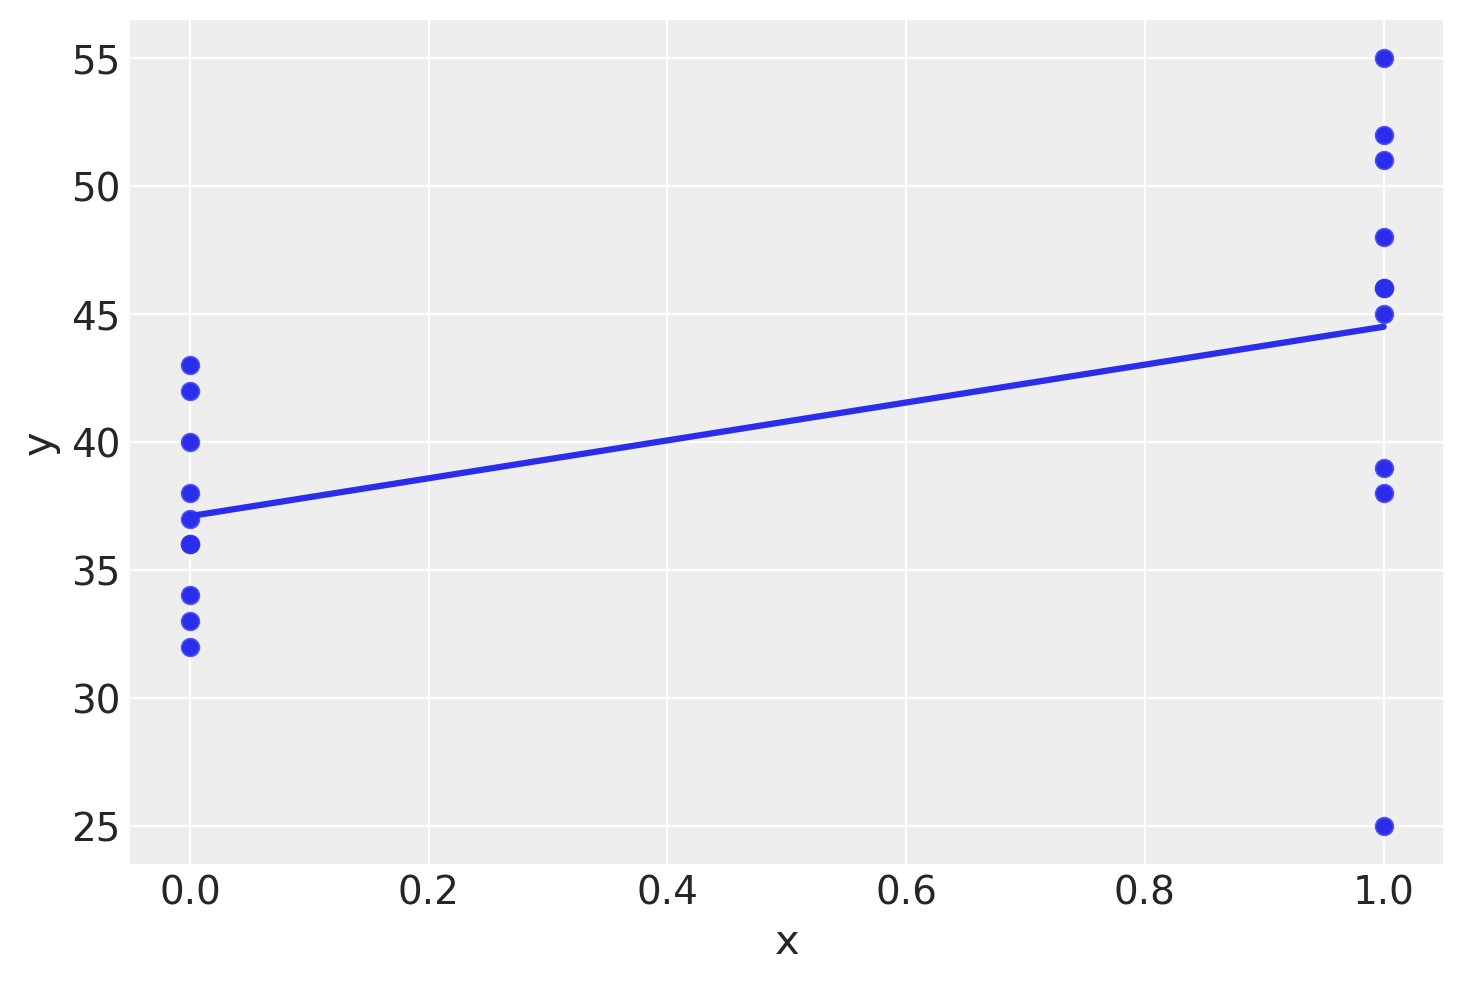

In [24]:
sns.scatterplot(x=df["x"], y=df["y"])
sns.regplot(x=df["x"], y=df["y"], ci=False)

In [25]:
with Model() as model_p:

    # Priors
    alpha = Normal("alpha", mu=0, sigma=50)
    beta = Normal("beta", mu=0, sigma=100)
    sigma = pm.HalfNormal("sigma", sigma=50)

    # Expected value of outcome
    mu = alpha + beta * x

    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    idata_p = pm.sample_prior_predictive(samples=50)

Sampling: [Y_obs, alpha, beta, sigma]


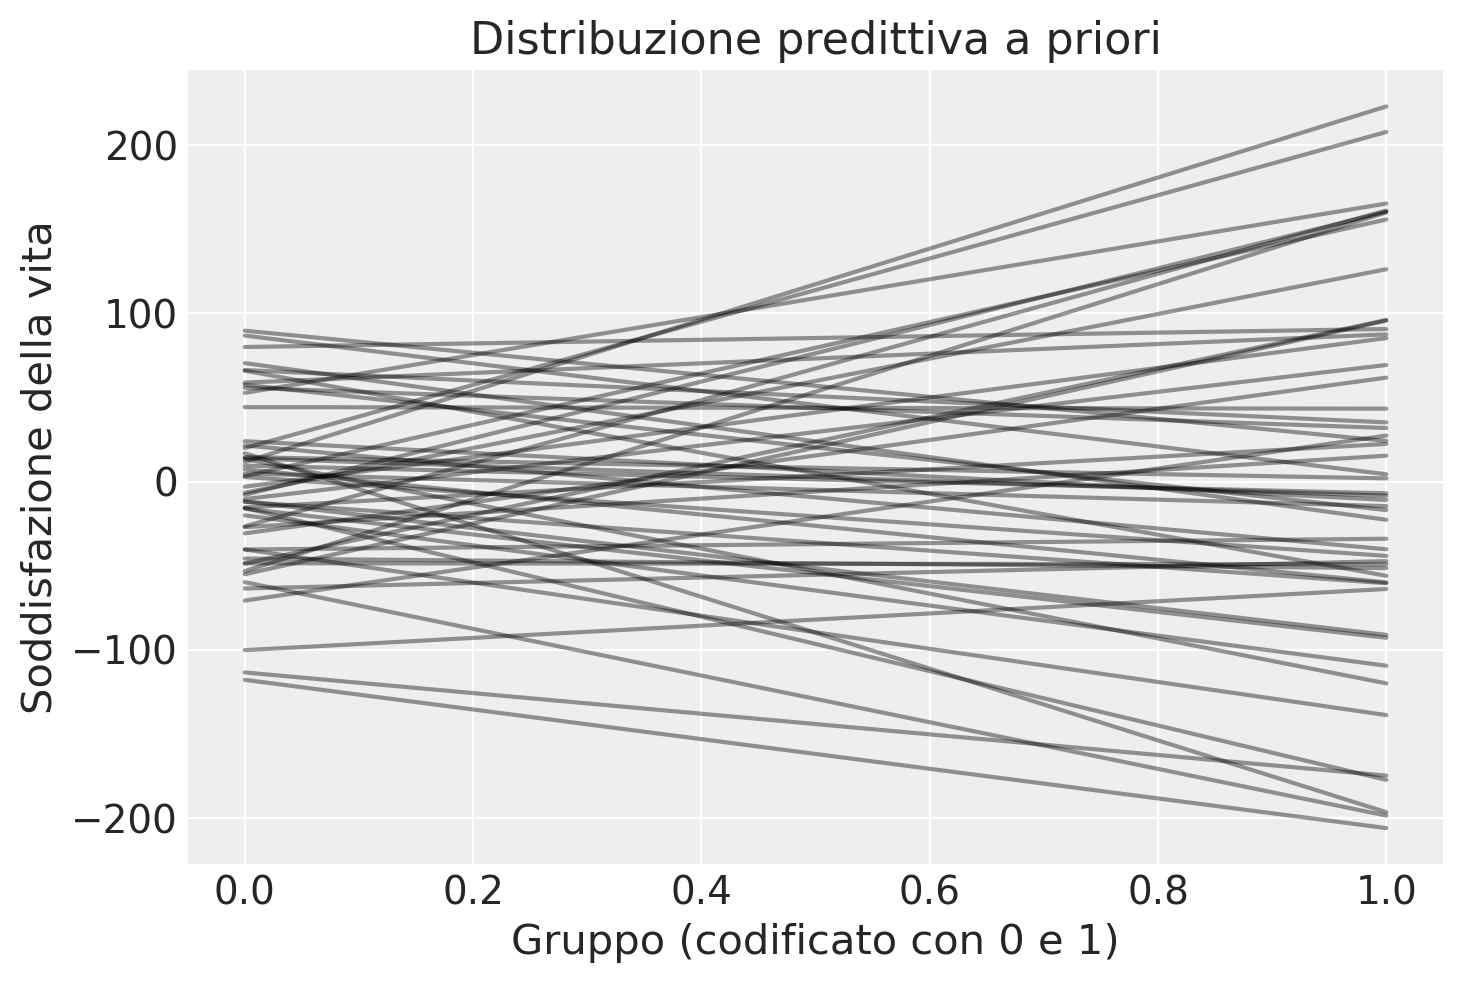

In [26]:
_, ax = plt.subplots()

xp = xr.DataArray(np.linspace(0, 1, 11), dims=["plot_dim"])
prior = idata_p.prior
yp = prior["alpha"] + prior["beta"] * xp

ax.plot(xp, yp.stack(sample=("chain", "draw")), c="k", alpha=0.4)

ax.set_ylabel("Soddisfazione della vita")
ax.set_xlabel("Gruppo (codificato con 0 e 1)")
ax.set_title("Distribuzione predittiva a priori");

In [27]:
prior["alpha"]

<xarray.DataArray 'alpha' (chain: 1, draw: 50)> Size: 400B
array([[  14.49726293,  -70.82734058,  -48.80995106,   55.79201415,
          21.46305183,    7.29042185,   58.83623803,   80.03104038,
           4.73637818,  -63.62968423,   11.66888028,  -59.88045681,
         -30.83245623,    2.69890969,   86.81871374,  -40.4629559 ,
        -117.98983686,   52.74570683,   -6.6660523 , -100.32200194,
         -12.08662152,   16.79951637,  -20.11142425,    9.47734011,
         -10.44344721,   89.73702438, -113.59842242,  -53.2811958 ,
         -15.74897874,   13.46326117,  -11.83049021,   -3.09798462,
         -16.16154227,  -45.8493326 ,   44.25553195,   66.31155623,
          23.97507448,   70.44826302,    3.21772945,  -26.70465797,
         -55.15168978,  -40.40706037,   -7.93283091,   57.57619194,
          13.81244114,  -27.17751076,   19.87322207,  -48.63143829,
          65.92577476,  -15.46636497]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49

In [28]:
prior["beta"]

<xarray.DataArray 'beta' (chain: 1, draw: 50)> Size: 400B
array([[ -12.62992004,   98.18101837,  144.9146564 ,  -23.94003315,
         -61.78620908,  -67.32338175,   28.70629804,   10.69765301,
         -19.3966999 ,   16.25540781,  211.49774783, -138.87485764,
          92.62973613,  -46.95649421,  -82.49447664,    6.41197764,
         -88.20307013,  112.63646745,  132.94946534,   36.36820154,
         -48.43327032, -213.51949542,  -89.47854466,  -16.49334644,
          79.76301123,  -65.57019626,  -61.38427131,  213.39680534,
        -161.75336697, -133.55893501,  -79.41144563,   88.41226788,
         -76.7855195 ,   -5.66183123,   -0.91723598,  -31.13709654,
         -34.92527694,  -93.22029026,  152.67888496,  187.91005993,
         150.88560496,  -98.56170821,  168.44928811,  -74.57627776,
         -22.27495738,   42.54191447,  188.08954667,   -0.6002865 ,
        -122.0237049 ,   37.82355396]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49

In [29]:
xp.shape

(11,)

In [30]:
xp

<xarray.DataArray (plot_dim: 11)> Size: 88B
array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])
Dimensions without coordinates: plot_dim

In [31]:
yp

<xarray.DataArray (chain: 1, draw: 50, plot_dim: 11)> Size: 4kB
array([[[ 1.44972629e+01,  1.32342709e+01,  1.19712789e+01,
          1.07082869e+01,  9.44529491e+00,  8.18230291e+00,
          6.91931090e+00,  5.65631890e+00,  4.39332690e+00,
          3.13033489e+00,  1.86734289e+00],
        [-7.08273406e+01, -6.10092387e+01, -5.11911369e+01,
         -4.13730351e+01, -3.15549332e+01, -2.17368314e+01,
         -1.19187296e+01, -2.10062772e+00,  7.71747411e+00,
          1.75355760e+01,  2.73536778e+01],
        [-4.88099511e+01, -3.43184854e+01, -1.98270198e+01,
         -5.33555414e+00,  9.15591150e+00,  2.36473771e+01,
          3.81388428e+01,  5.26303084e+01,  6.71217741e+01,
          8.16132397e+01,  9.61047053e+01],
        [ 5.57920141e+01,  5.33980108e+01,  5.10040075e+01,
          4.86100042e+01,  4.62160009e+01,  4.38219976e+01,
          4.14279943e+01,  3.90339909e+01,  3.66399876e+01,
          3.42459843e+01,  3.18519810e+01],
        [ 2.14630518e+01,  1.52844309e+01,  9.10581002e+00,
          2.92718911e+00, -3.25143180e+00, -9.43005271e+00,
         -1.56086736e+01, -2.17872945e+01, -2.79659154e+01,
         -3.41445363e+01, -4.03231572e+01],
...
        [-2.71775108e+01, -2.29233193e+01, -1.86691279e+01,
         -1.44149364e+01, -1.01607450e+01, -5.90655352e+00,
         -1.65236207e+00,  2.60182937e+00,  6.85602082e+00,
          1.11102123e+01,  1.53644037e+01],
        [ 1.98732221e+01,  3.86821767e+01,  5.74911314e+01,
          7.63000861e+01,  9.51090407e+01,  1.13917995e+02,
          1.32726950e+02,  1.51535905e+02,  1.70344859e+02,
          1.89153814e+02,  2.07962769e+02],
        [-4.86314383e+01, -4.86914669e+01, -4.87514956e+01,
         -4.88115242e+01, -4.88715529e+01, -4.89315815e+01,
         -4.89916102e+01, -4.90516388e+01, -4.91116675e+01,
         -4.91716961e+01, -4.92317248e+01],
        [ 6.59257748e+01,  5.37234043e+01,  4.15210338e+01,
          2.93186633e+01,  1.71162928e+01,  4.91392231e+00,
         -7.28844818e+00, -1.94908187e+01, -3.16931892e+01,
         -4.38955597e+01, -5.60979301e+01],
        [-1.54663650e+01, -1.16840096e+01, -7.90165418e+00,
         -4.11929879e+00, -3.36943390e-01,  3.44541201e+00,
          7.22776740e+00,  1.10101228e+01,  1.47924782e+01,
          1.85748336e+01,  2.23571890e+01]]])
Coordinates:
  * chain    (chain) int64 8B 0
  * draw     (draw) int64 400B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
Dimensions without coordinates: plot_dim

In [32]:
with Model() as model:

    # Priors
    alpha = Normal("alpha", mu=0, sigma=50)
    beta = Normal("beta", mu=0, sigma=50)
    sigma = pm.HalfNormal("sigma", sigma=50)

    # Expected value of outcome
    mu = alpha + beta * x

    # Likelihood of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=y)

    # Sampling
    idata = pm.sample()

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


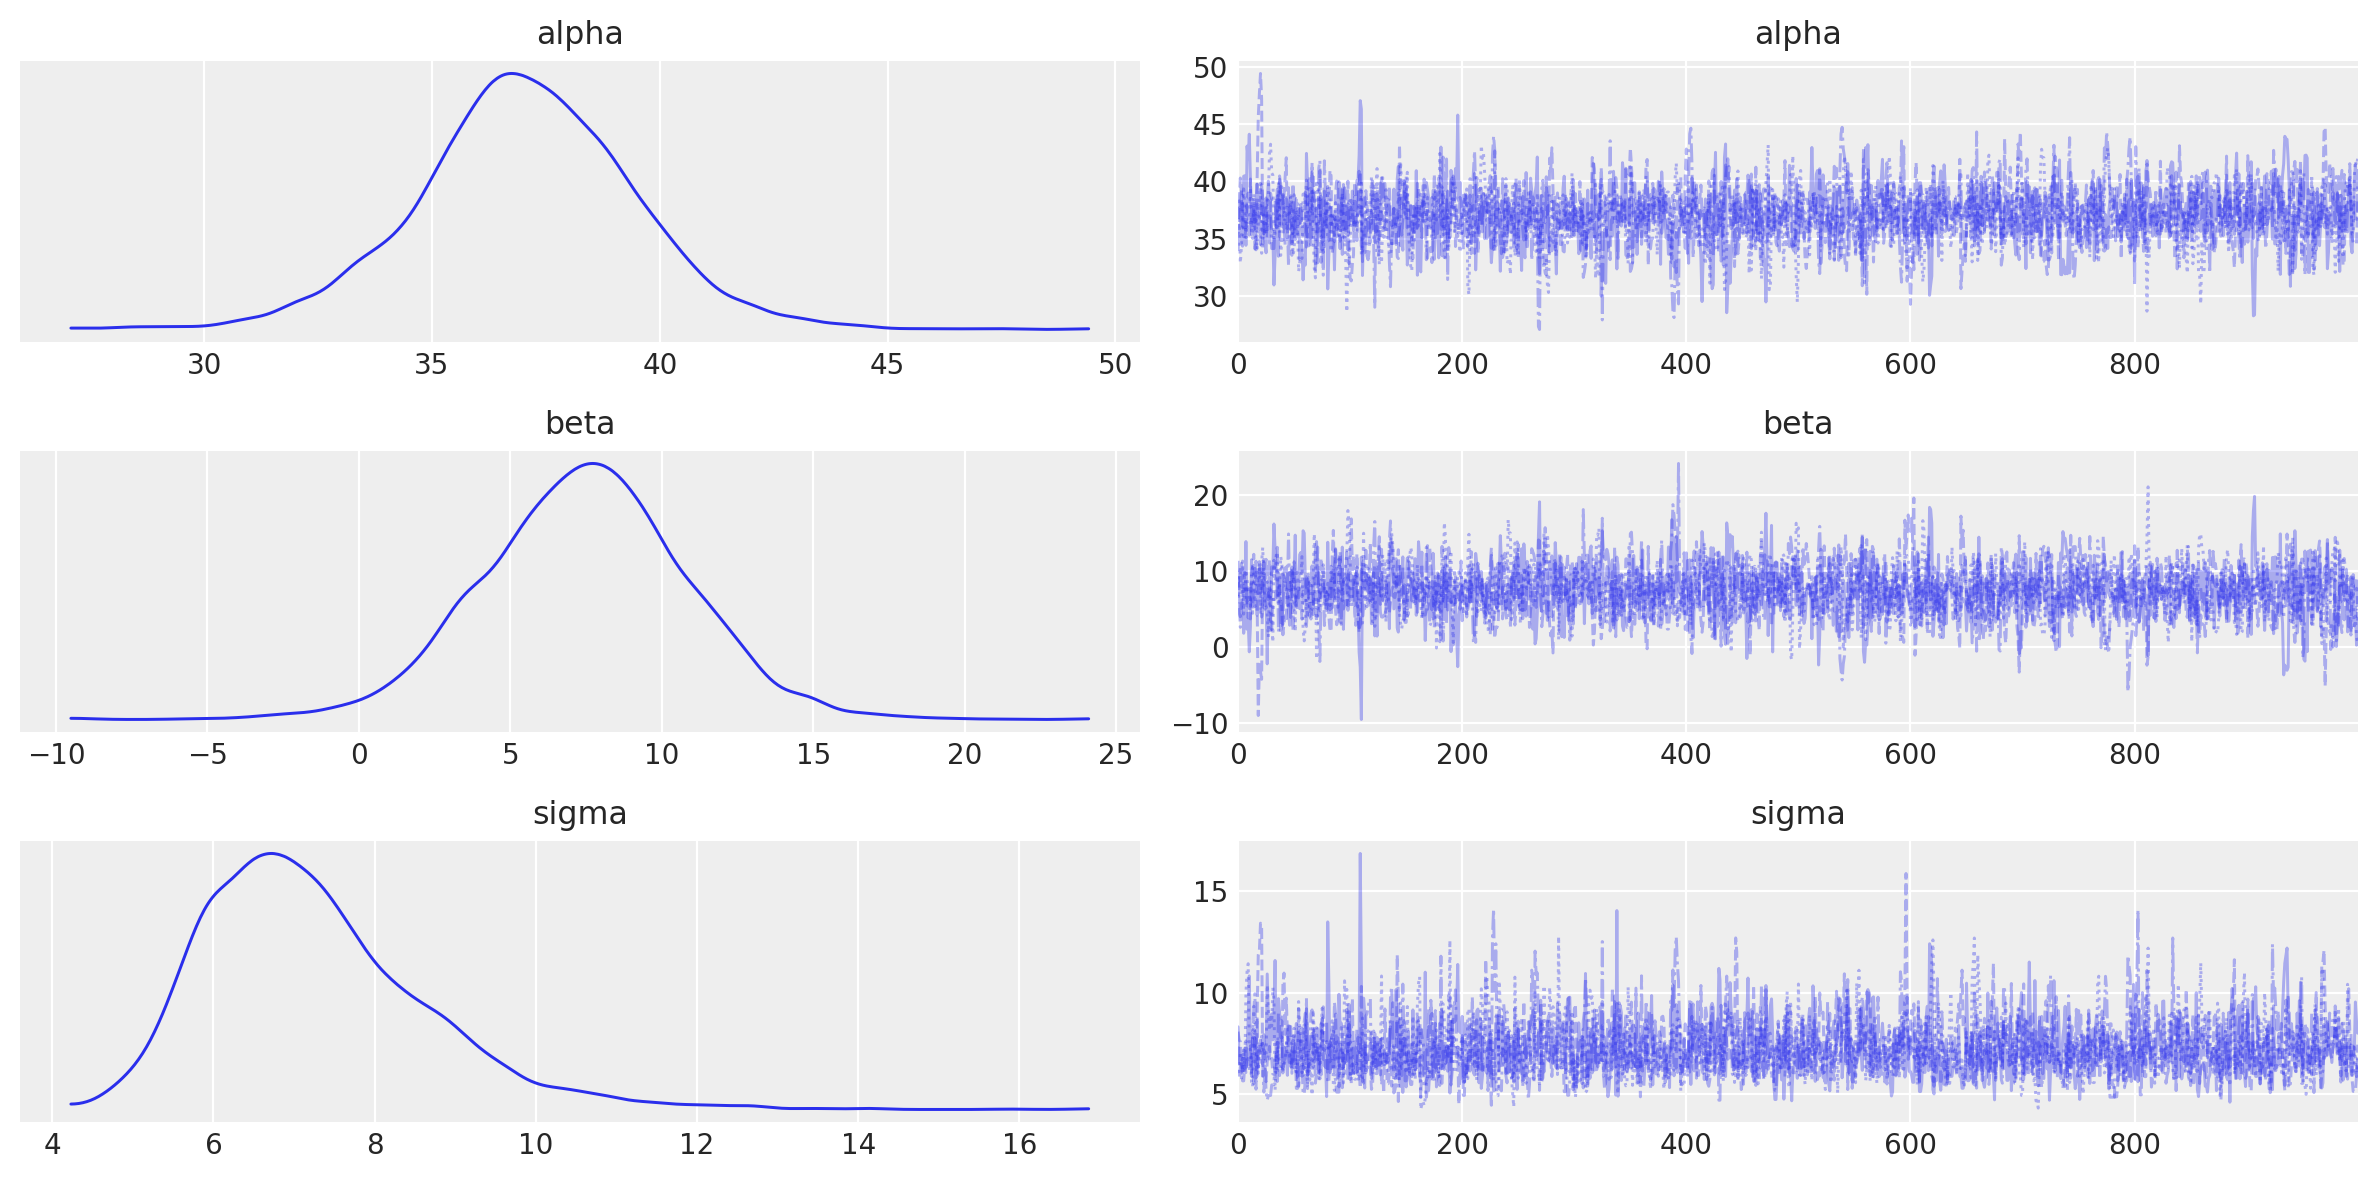

In [33]:
_ = az.plot_trace(idata, combined=True)
plt.tight_layout()

In [34]:
np.mean(older)

37.1

In [35]:
np.mean(younger) - np.mean(older)

7.399999999999999

In [36]:
az.summary(idata, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,37.045,2.406,31.820,41.402,0.057,0.041,1806.0,1947.0,1.01
beta,7.424,3.389,0.503,13.723,0.080,0.058,1820.0,1938.0,1.00
sigma,7.230,1.380,4.813,9.841,0.031,0.022,1958.0,2387.0,1.00


In [37]:
with model:
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling: [Y_obs]


Output()

In [38]:
idata.posterior_predictive

<xarray.Dataset> Size: 648kB
Dimensions:      (chain: 4, draw: 1000, Y_obs_dim_2: 20)
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 8kB 0 1 2 3 4 5 6 ... 993 994 995 996 997 998 999
  * Y_obs_dim_2  (Y_obs_dim_2) int64 160B 0 1 2 3 4 5 6 ... 13 14 15 16 17 18 19
Data variables:
    Y_obs        (chain, draw, Y_obs_dim_2) float64 640kB 61.27 47.68 ... 37.76
Attributes:
    created_at:                 2024-06-16T07:52:34.185451+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.15.1

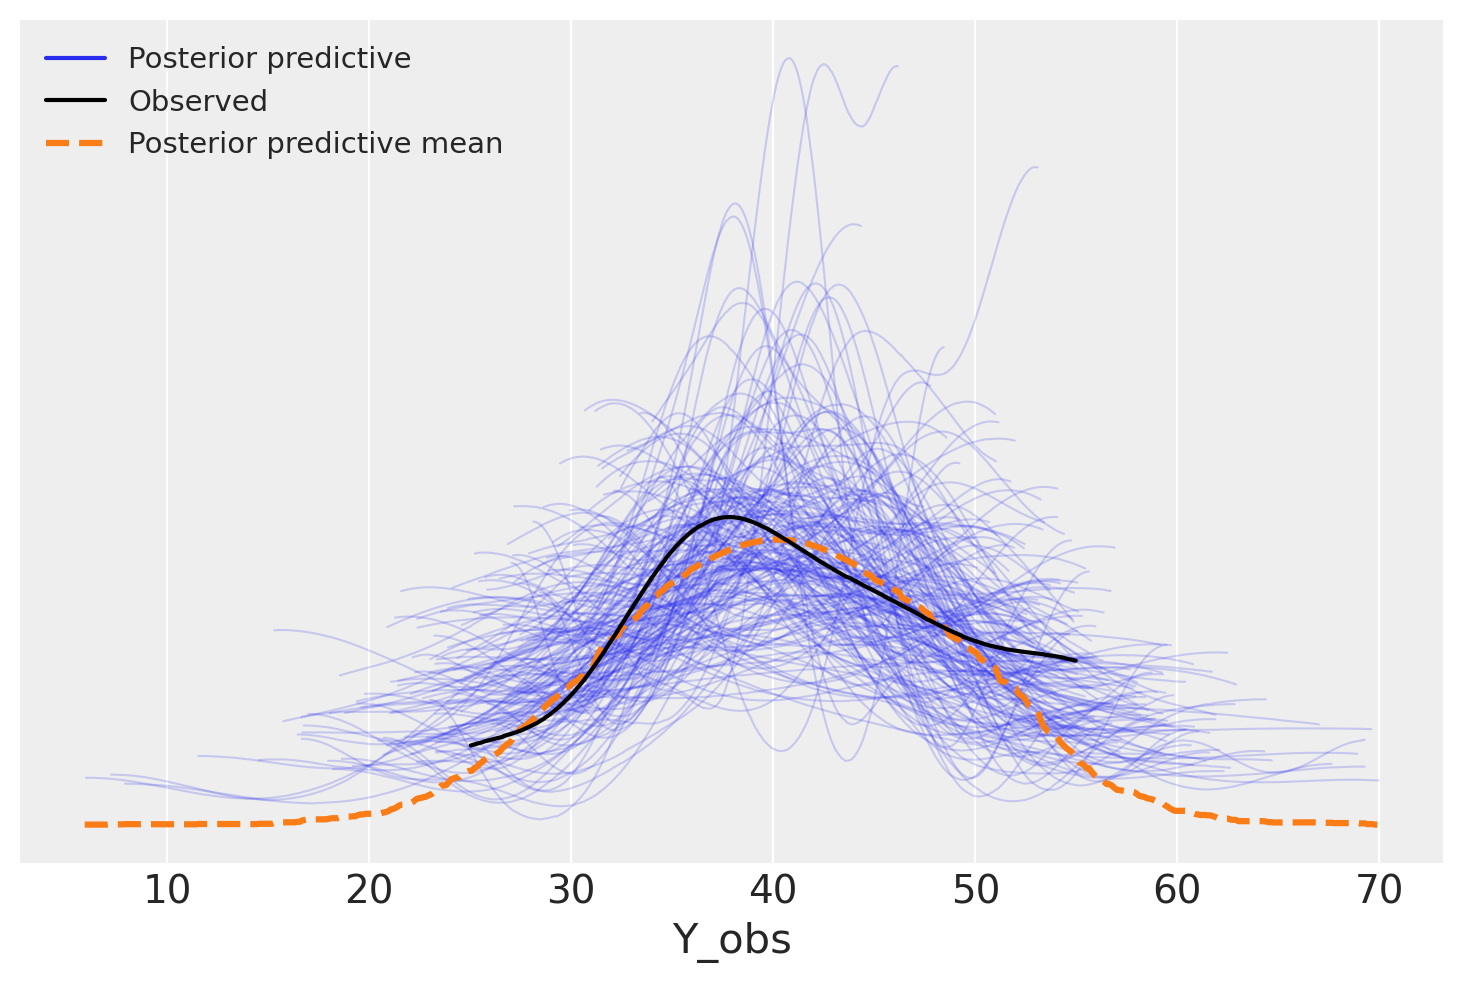

In [39]:
az.plot_ppc(idata, num_pp_samples=200);

In [40]:
pg.linear_regression(df['x'], df['y'])

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,37.1,2.110029,17.582697,8.790692e-13,0.25465,0.213242,32.666994,41.533006
1,x,7.4,2.984032,2.479867,2.326024e-02,0.25465,0.213242,1.130782,13.669218


In [41]:
df_star = pd.read_csv("../data/STAR.csv")
df_star.head()

,classtype,reading,math,graduated
0,small,578,610,1
1,regular,612,612,1
2,regular,583,606,1
3,small,661,648,1
4,small,614,636,1


In [42]:
group_means = df_star.groupby('classtype')["reading"].mean()
print(group_means)

classtype
regular    625.492017
small      632.702564
Name: reading, dtype: float64


<Axes: xlabel='classtype', ylabel='reading'>

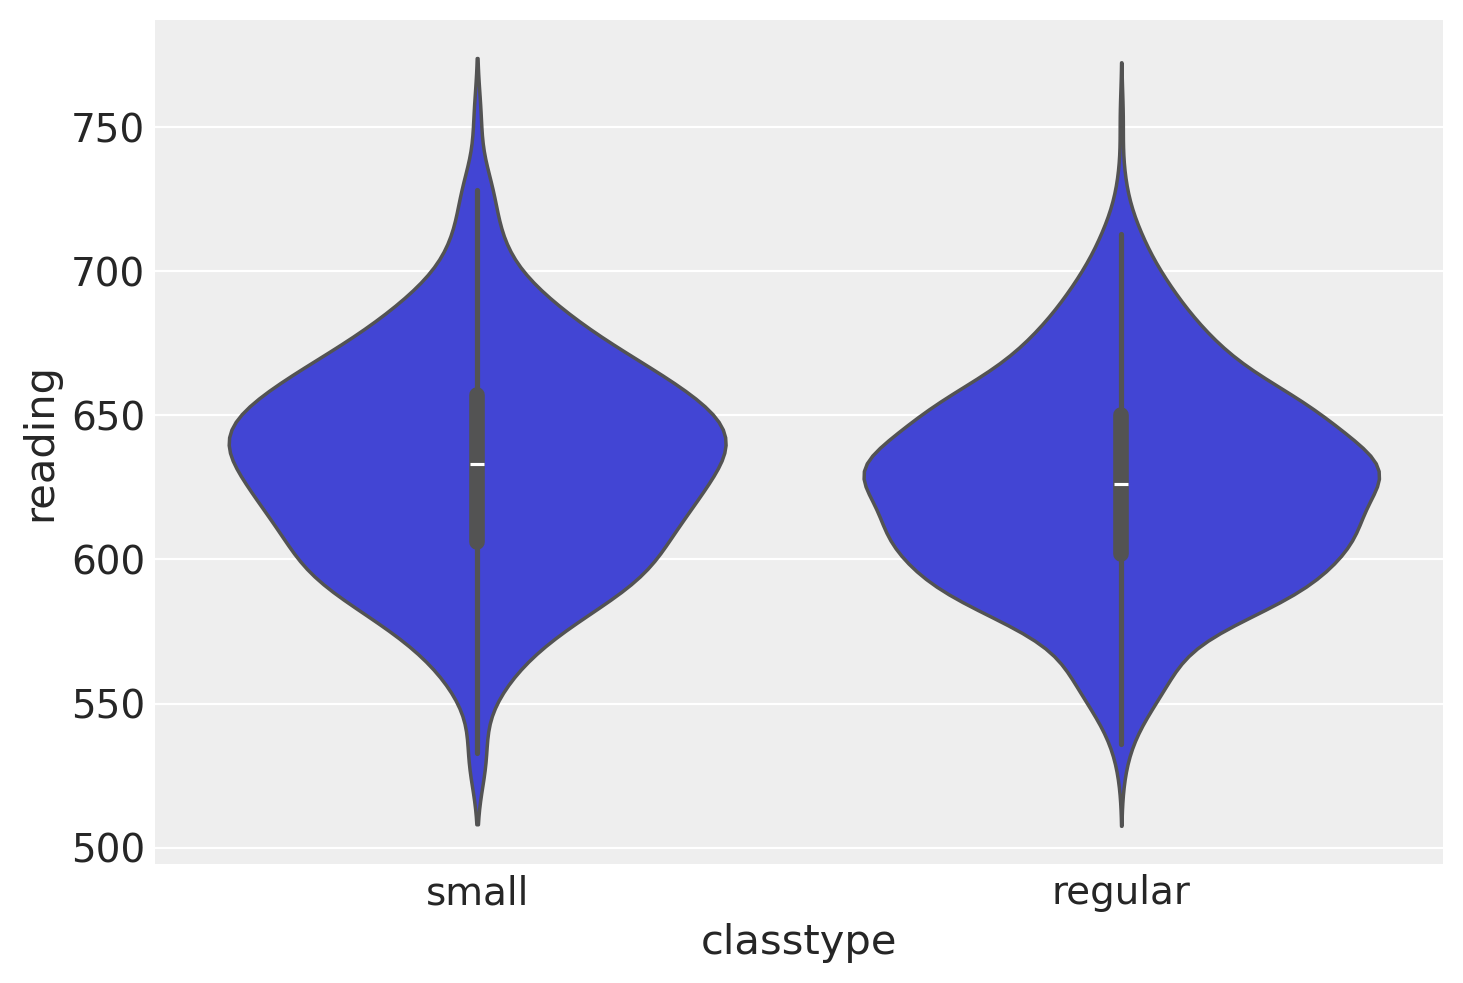

In [43]:
sns.violinplot(x="classtype", y="reading", data=df_star)

In [44]:
df_small = df_star[df_star['classtype'] == 'small']
df_regular = df_star[df_star['classtype'] == 'regular']

In [45]:
res = pg.ttest(df_small["reading"], df_regular["reading"], paired=False)
print(res)

               T          dof alternative    p-val          CI95%   cohen-d  \
T-test  3.495654  1220.993525   two-sided  0.00049  [3.16, 11.26]  0.197183   

          BF10     power  
T-test  25.771  0.938789  


In [46]:
mean_diff = np.mean(df_small["reading"]) - np.mean(df_regular["reading"])
mean_diff

7.210546686018347

In [47]:
num_rows = df_star.shape[0]
num_rows

1274

In [48]:
dof = 2 * num_rows - 2
dof

2546

In [49]:
t_c = st.t.ppf(0.975, dof)
t_c

1.9608961841574426

In [50]:
se_diff = np.sqrt(
    np.var(df_small["reading"], ddof=1) / len(df_small["reading"]) +
    np.var(df_regular["reading"], ddof=1) / len(df_regular["reading"])
    )
se_diff

2.0627173626882493

In [51]:
T = mean_diff / se_diff
print(T)

3.4956542357413216


In [52]:
(1 - st.t.cdf(T, df=dof)) * 2

0.0004809856733483109

In [53]:
pm = np.array([-1, +1])
ci = mean_diff + pm * (t_c * se_diff)
print(ci)

[ 3.16577208 11.25532129]


In [54]:
p = 0.6
n = 10
X = st.bernoulli(p)
Y = [X.rvs(n) for i in range(10000)]

In [55]:
Y[0:5]

[array([0, 1, 0, 1, 1, 1, 1, 1, 0, 0]),
 array([1, 1, 1, 0, 0, 0, 1, 1, 1, 1]),
 array([1, 1, 0, 1, 1, 0, 0, 1, 0, 0]),
 array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1]),
 array([0, 0, 1, 0, 0, 1, 1, 0, 0, 1])]

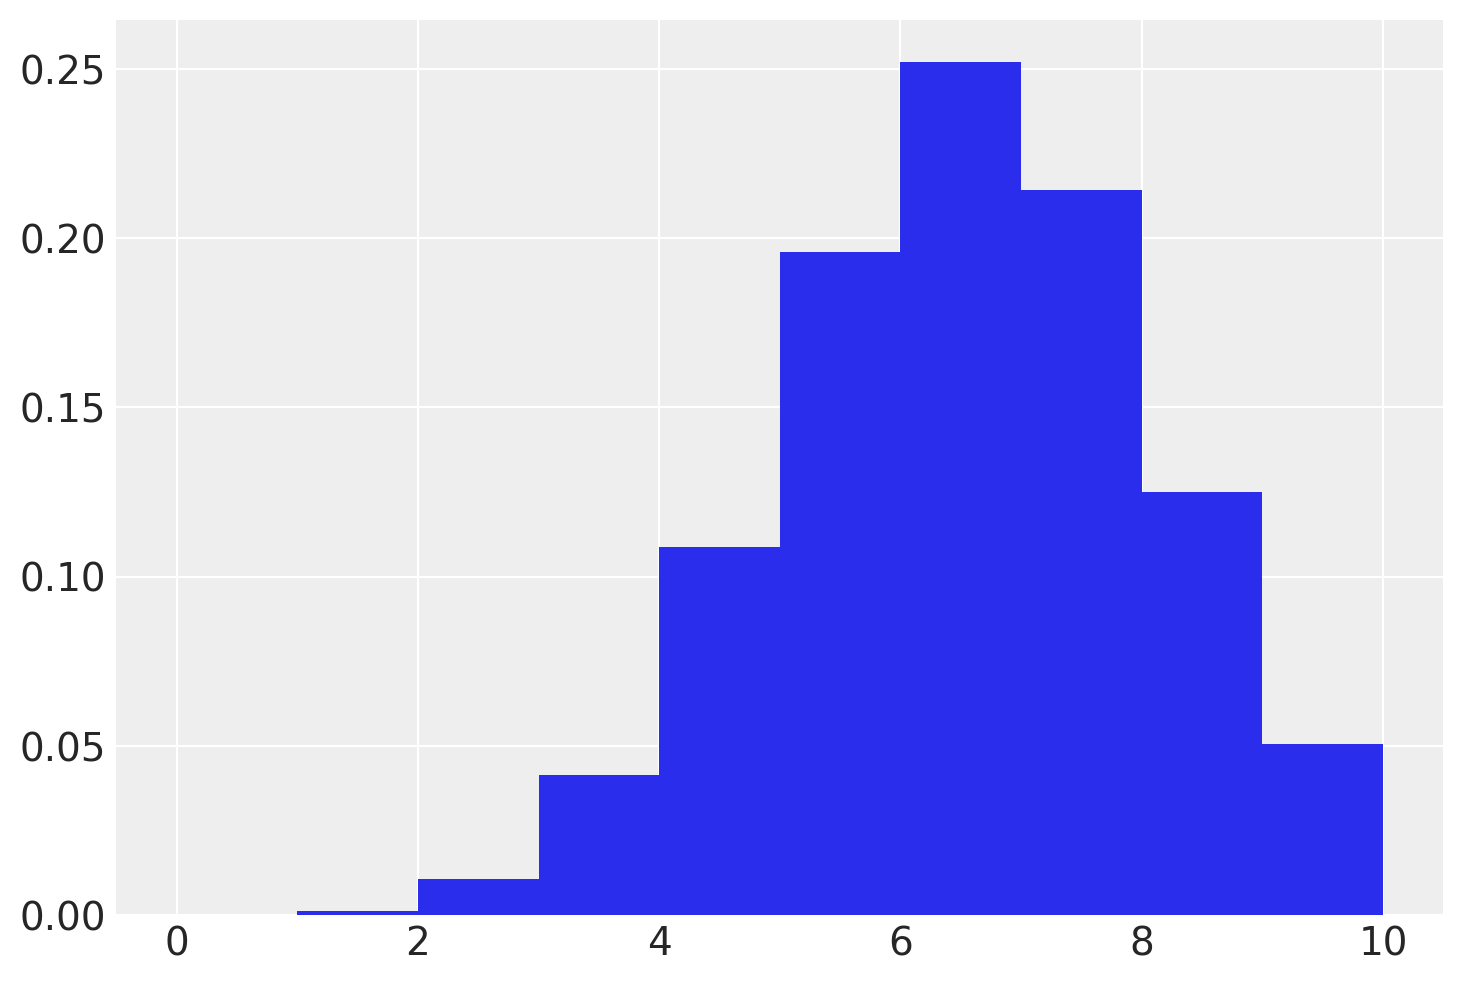

In [56]:
_ = plt.hist(np.sum(Y, axis=1), density=True)

In [57]:
print('Media empirica della distribuzione campionaria: {}'.format(np.mean(np.mean(Y, axis=1))))
print('Valore teorico atteso: {}'.format(p))

Media empirica della distribuzione campionaria: 0.60346
Valore teorico atteso: 0.6


In [58]:
print('Stima empirica della deviazione standard: {}'.format(np.std(np.mean(Y, axis=1))))
print('Deviazione standard teorica: {}'.format(np.sqrt(p*(1-p)/n)))

Stima empirica della deviazione standard: 0.15576273110086378
Deviazione standard teorica: 0.15491933384829668


In [59]:
p = 0.03
n = 400
X = st.bernoulli(p)
Y = [X.rvs(n) for i in range(10000)]

In [60]:
print('Media empirica della distribuzione campionaria: {}'.format(np.mean(np.mean(Y, axis=1))))
print('Valore teorico atteso: {}'.format(p))

Media empirica della distribuzione campionaria: 0.029996500000000002
Valore teorico atteso: 0.03


In [61]:
print('Stima empirica della deviazione standard: {}'.format(np.std(np.mean(Y, axis=1))))
print('Deviazione standard teorica: {}'.format(np.sqrt(p*(1-p)/n)))

Stima empirica della deviazione standard: 0.008398659878218667
Deviazione standard teorica: 0.00852936105461599


In [62]:
np.mean(Y, axis=1)

array([0.0175, 0.04  , 0.02  , ..., 0.025 , 0.0375, 0.025 ])

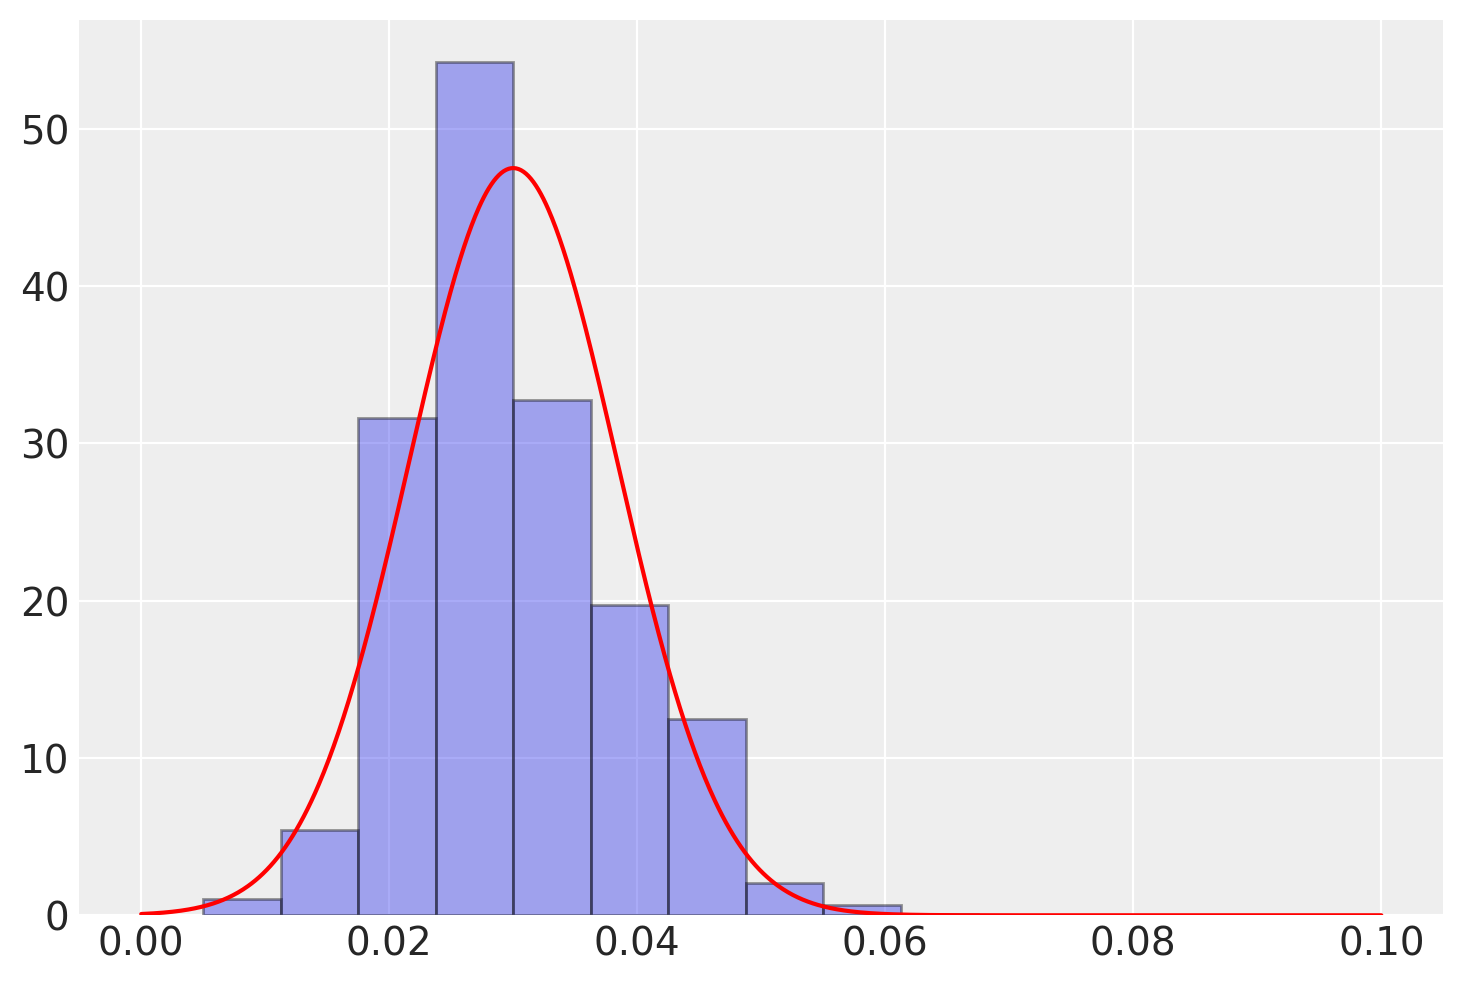

In [63]:
y = np.mean(Y, axis=1)
sns.distplot(y, bins=10, hist=True, kde=False, norm_hist=True, hist_kws={'edgecolor':'black'})
x = np.linspace(0, 0.1, 1000)
y = st.norm.pdf(x, np.mean(y), np.std(y))  # Normal density values
plt.plot(x, y, 'r-', label='Normal Density')

In [64]:
bes = pd.read_csv("../data/BES.csv")
bes.head()

,vote,leave,education,age
0,leave,1.0,3.0,60
1,leave,1.0,NaN,56
2,stay,0.0,5.0,73
3,leave,1.0,4.0,64
4,don't know,NaN,2.0,68


In [65]:
bes.shape

(30895, 4)

In [66]:
bes_cleaned = bes.dropna()
bes_cleaned.shape

(25097, 4)

In [67]:
bes_cleaned["leave"].mean()

0.47188907040682154

In [68]:
n = bes_cleaned.shape[0]
n

25097

In [69]:
p = bes_cleaned["leave"].mean()
se = np.sqrt(p * (1 - p) / n)
print(se)

0.0031511685382488307


In [70]:
pm = np.array([-1, +1])
ci = np.mean(bes_cleaned["leave"]) + pm * st.norm.ppf(0.975) * se
print(f"L'intervallo di fiducia al 95% è [{ci[0]:.4f}, {ci[1]:.4f}].")

L'intervallo di fiducia al 95% è [0.4657, 0.4781].


<Axes: xlabel='leave', ylabel='age'>

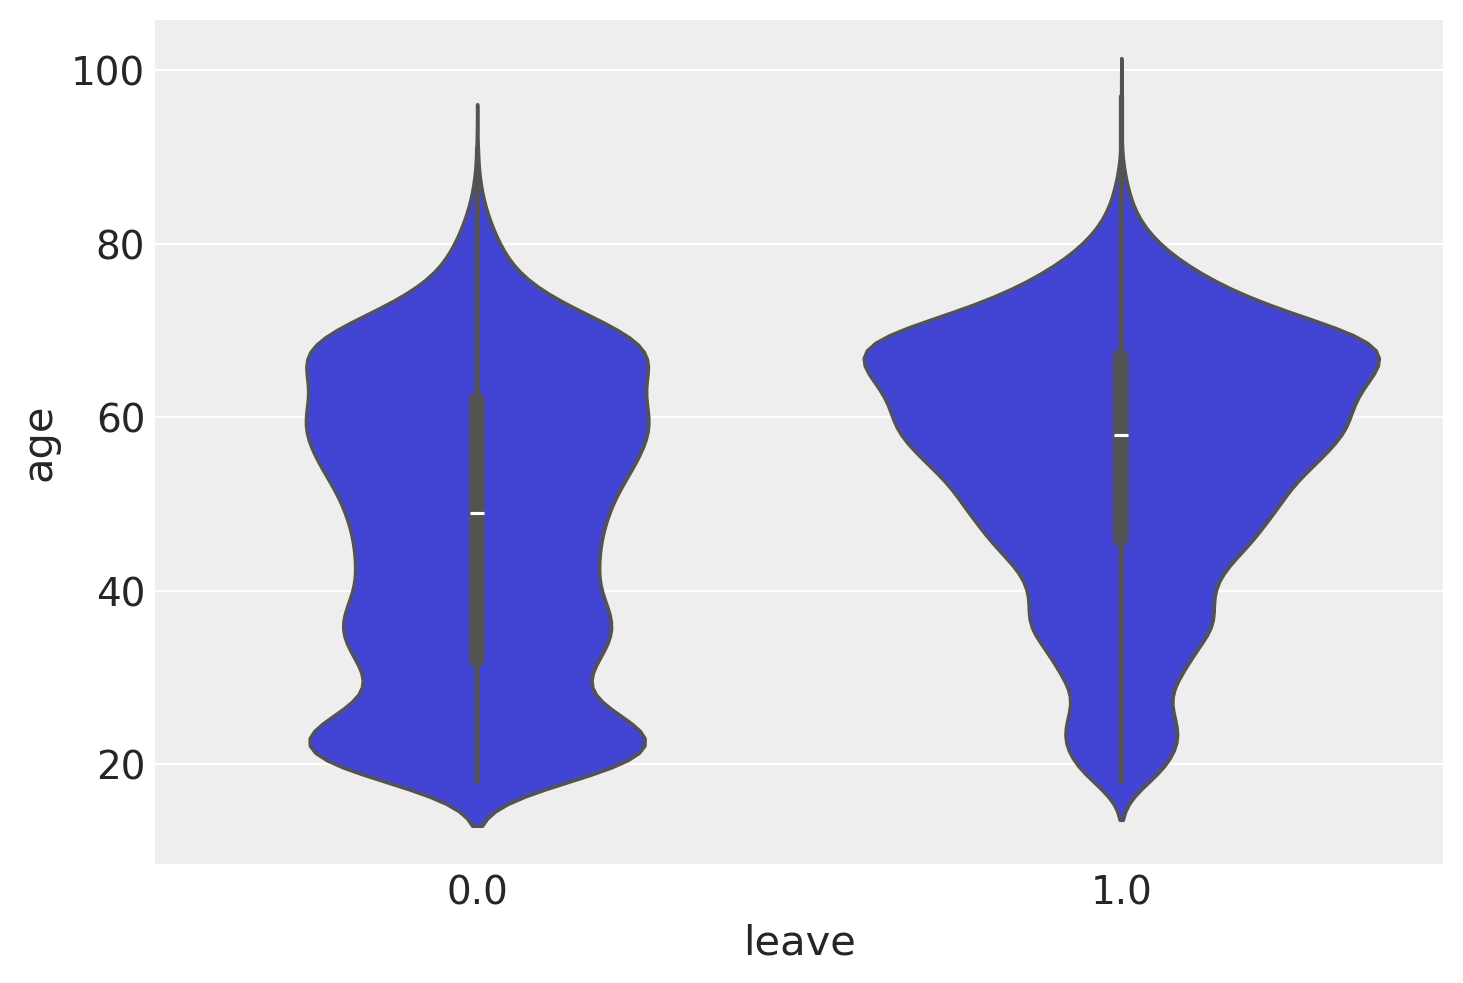

In [71]:
sns.violinplot(x="leave", y="age", data=bes)

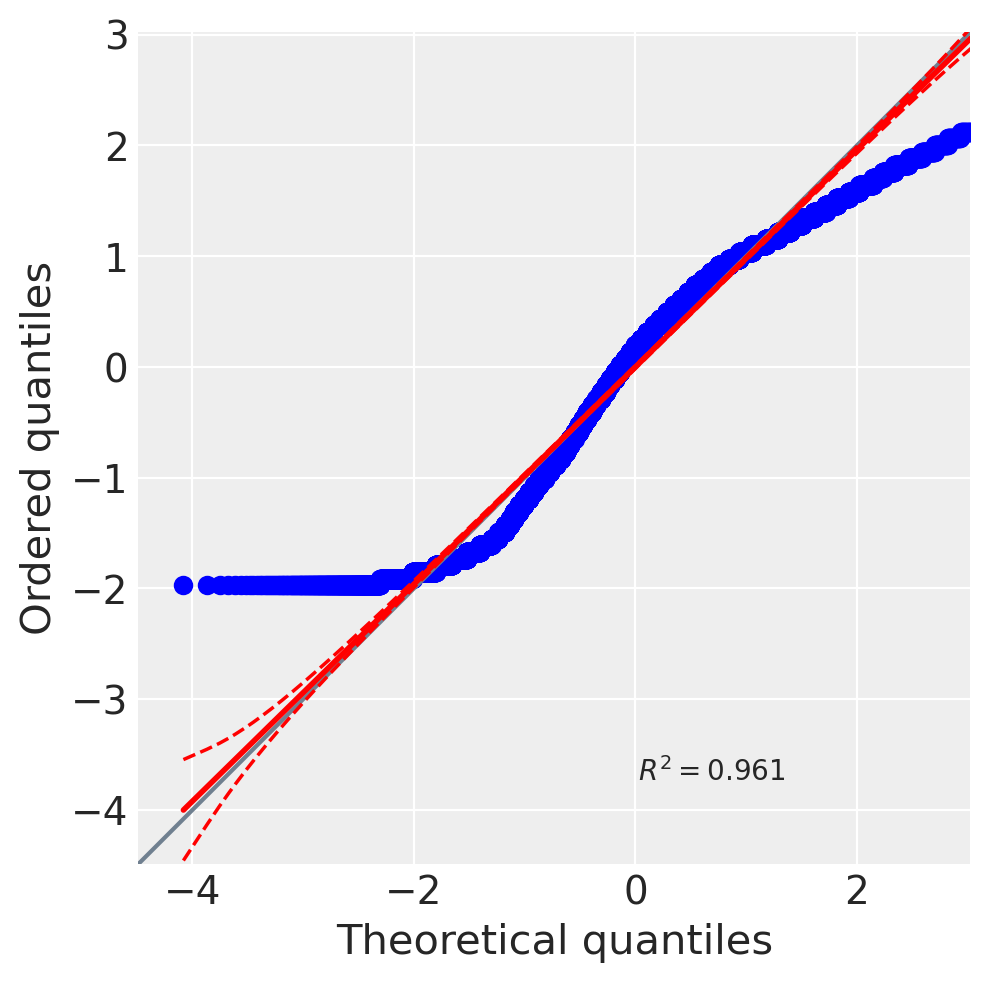

In [72]:
ax = pg.qqplot(bes["age"], dist="norm")

<Axes: xlabel='age', ylabel='Density'>

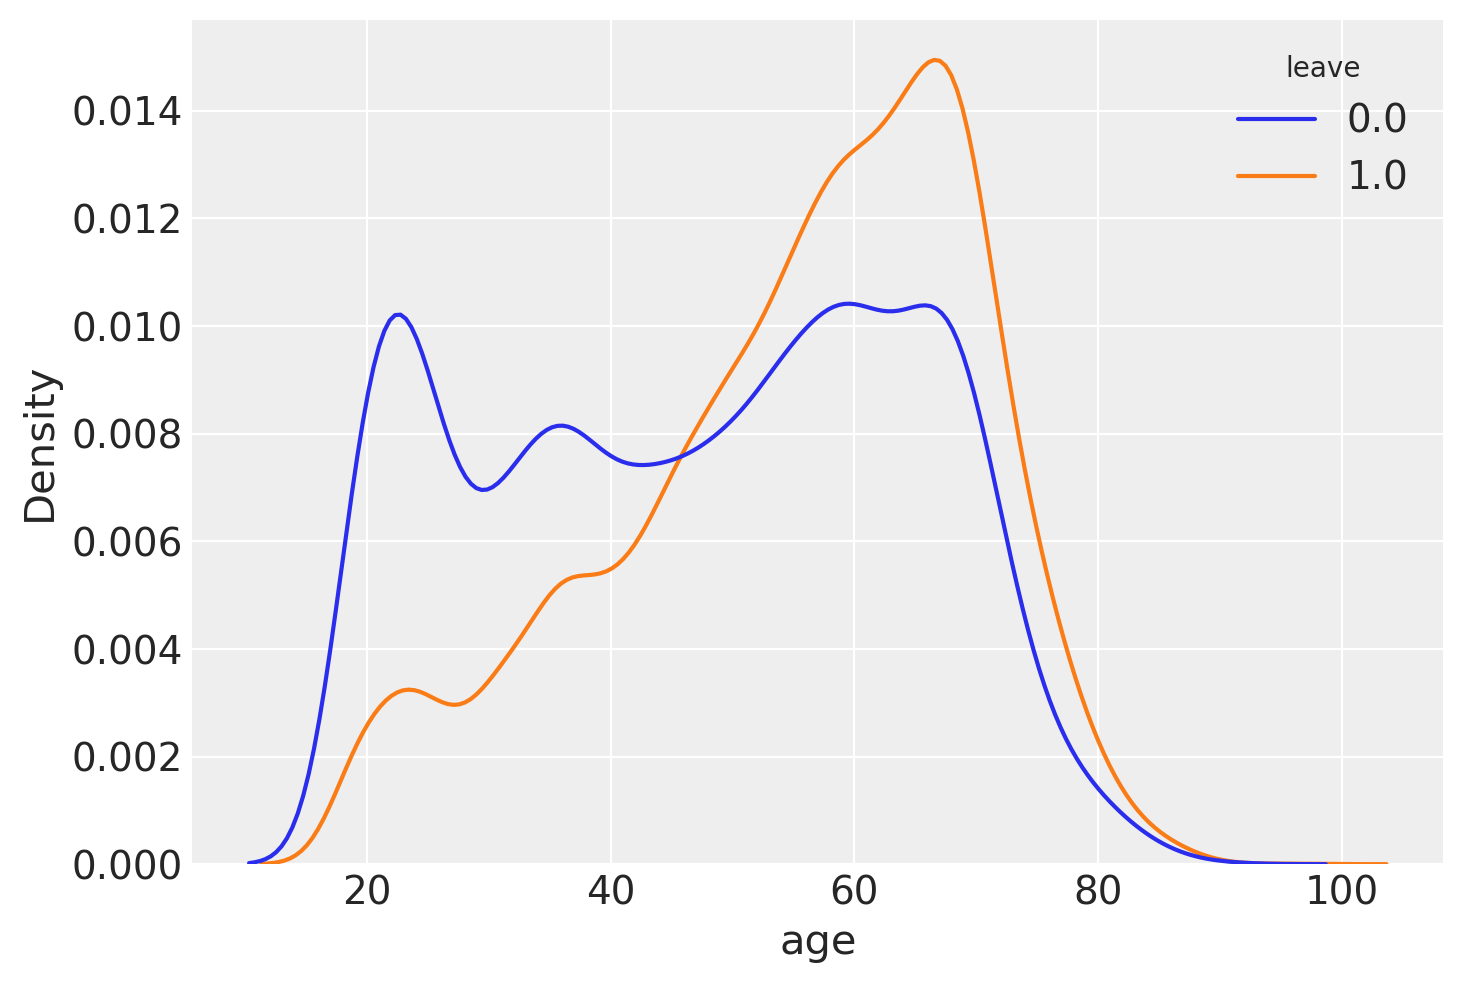

In [73]:
sns.kdeplot(data=bes, x="age", hue="leave")

In [74]:
leave_df = bes[bes["leave"] == 1]
stay_df = bes[bes["leave"] == 0]

In [75]:
res = pg.ttest(leave_df["age"], stay_df["age"], paired=False)
print(res)

                T           dof alternative  p-val         CI95%   cohen-d  \
T-test  41.588603  27738.840259   two-sided    0.0  [7.63, 8.38]  0.495062   

       BF10  power  
T-test  inf    1.0  


In [76]:
n_l = leave_df.shape[0]
n_l

13692

In [77]:
n_s = stay_df.shape[0]
n_s

14352

In [78]:
n_l + n_s - 2

28042

In [79]:
se = np.sqrt(
    (np.var(leave_df["age"], ddof=1) / n_l) + 
    (np.var(stay_df["age"], ddof=1) / n_s)
) 
se

0.19250126816432642

In [80]:
T = (np.mean(leave_df["age"]) - np.mean(stay_df["age"])) / se

In [81]:
2 * st.t.sf(T, df = n_l + n_s - 2)

0.0

In [82]:
t_c = st.t.ppf(0.975, df=n_l + n_s - 2)
t_c

1.9600485852064147

In [83]:
pm = np.array([-1, +1])
ci = (np.mean(leave_df["age"]) - np.mean(stay_df["age"])) + pm * t_c * se
print(f"L'intervallo di fiducia al 95% è [{ci[0]:.2f}, {ci[1]:.2f}].")

L'intervallo di fiducia al 95% è [7.63, 8.38].


In [84]:
np.mean(leave_df["age"]) - np.mean(stay_df["age"])

8.00585876624487

In [85]:
(8.38 - 7.63) / 2

0.37500000000000044

In [86]:
%load_ext watermark
%watermark -n -u -v -iv 

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

arviz     : 0.18.0
matplotlib: 3.8.4
xarray    : 2024.5.0
scipy     : 1.13.1
seaborn   : 0.13.2
numpy     : 1.26.4
pandas    : 2.2.2
pingouin  : 0.5.4

